In [ ]:
#%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import gdown
import zipfile

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
torch.use_deterministic_algorithms(True) # Needed for reproducible results
torch.cuda.get_device_name(0)

Mounted at /content/drive
Random Seed:  999


'Tesla T4'

In [ ]:
# Root directory for dataset
# dataroot = "/content/drive/MyDrive/Colab_dataset/celeba"
# dataroot = "Colab_dataset/celeba"

# model_save_path = "/content/model"
model_save_path = "/content/drive/MyDrive/Colab_models/Brain_MRI_image_synthesis/DCGAN_brain_mri_trained"

# Root directory for the dataset
# data_root = 'data/celeba'
data_root = 'data/brain_mri'
# Path to folder with individual images
# img_folder = f'{data_root}/img_align_celeba'
img_folder = f'{data_root}/brain_mri_combined'

# URL for the CelebA dataset
# url = 'https://drive.google.com/file/d/15E43foOW_1J2mfRRy_Ps663tk0N65egv/view?usp=drive_link'
# url = 'https://drive.google.com/uc?id=15E43foOW_1J2mfRRy_Ps663tk0N65egv'
url = 'https://drive.google.com/uc?id=1oA06D2-HSk_JqDe_rheK0OutyG-Gysd-'

# Path to download the dataset to
download_path = f'{data_root}/img_align_celeba.zip'
download_path = f'{data_root}/Brain_MRI.zip'

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 64

# Number of channels in the training images. For color images this is 3
nc = 3

# Size of z latent vector (i.e. size of generator input)
nz = 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 5

# Learning rate for optimizers
lr = 0.0002

# Beta1 hyperparameter for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

In [ ]:

# Create required directories
if not os.path.exists(data_root):
  os.makedirs(data_root)
  os.makedirs(img_folder)
if not os.path.exists(model_save_path):
  os.makedirs(model_save_path)

# Download the dataset from google drive
gdown.download(url, download_path, quiet=False)
with zipfile.ZipFile(download_path, 'r') as ziphandler:
  ziphandler.extractall(img_folder)

Downloading...
From (original): https://drive.google.com/uc?id=1oA06D2-HSk_JqDe_rheK0OutyG-Gysd-
From (redirected): https://drive.google.com/uc?id=1oA06D2-HSk_JqDe_rheK0OutyG-Gysd-&confirm=t&uuid=f7afc933-fa94-4bad-a234-f6356e317b4e
To: /content/data/brain_mri/Brain_MRI.zip
100%|██████████| 40.6M/40.6M [00:00<00:00, 88.3MB/s]


In [ ]:
!unzip -o -q '/content/data/celeba/img_align_celeba.zip' -d '/content/data/celeba'

[/content/data/celeba/img_align_celeba.zip]
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of /content/data/celeba/img_align_celeba.zip or
        /content/data/celeba/img_align_celeba.zip.zip, and cannot find /content/data/celeba/img_align_celeba.zip.ZIP, period.


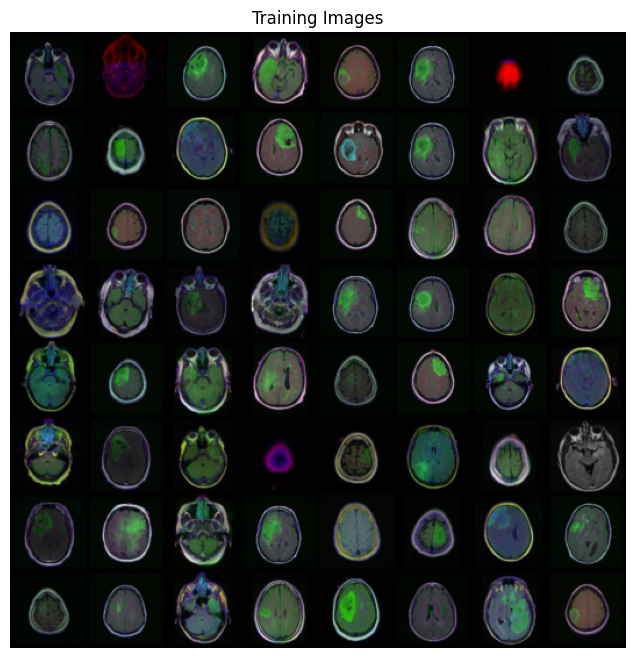

In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
transform=transforms.Compose([
                               transforms.Resize(image_size),
                               transforms.CenterCrop(image_size),
                               transforms.ToTensor(),
                               transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                           ])

# dataset = dset.ImageFolder(root=dataroot, transform=transform)

# Create a new root folder
# new_root_folder = os.path.join(dataroot,"Input_images")
new_root_folder = img_folder

# Create symbolic links to the desired image folders inside the new root folder
for folder in ['Notumor', 'Tumor']:
    source_path = os.path.join('/content',data_root,'Brain_MRI', folder)
    destination_path = os.path.join('/content',new_root_folder, folder)

    # Remove existing symbolic link if it exists
    if not os.path.exists(destination_path):
        # os.remove(destination_path)
        os.symlink(source_path, destination_path)


# Load the ImageFolder dataset using the new root folder
dataset = dset.ImageFolder(new_root_folder, transform=transform)

# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Decide which device we want to run on
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

# /content/drive/MyDrive/Colab_dataset/Brain_MRI/Notumor
# /content/data/brain_mri/Brain_MRI/Notumor

In [ ]:
!rm -rf /content/data/brain_mri/brain_mri_combined/.ipynb_checkpoints

In [ ]:
# custom weights initialization called on ``netG`` and ``netD``
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)

    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [ ]:
# Generator Code

class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            nn.ConvTranspose2d( nz, ngf * 8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            nn.ReLU(True),
            # state size. ``(ngf*8) x 4 x 4``
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.ReLU(True),
            # state size. ``(ngf*4) x 8 x 8``
            nn.ConvTranspose2d( ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.ReLU(True),
            # state size. ``(ngf*2) x 16 x 16``
            nn.ConvTranspose2d( ngf * 2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            # state size. ``(ngf) x 32 x 32``
            nn.ConvTranspose2d( ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size. ``(nc) x 64 x 64``
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is ``(nc) x 64 x 64``
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf) x 32 x 32``
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*2) x 16 x 16``
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*4) x 8 x 8``
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size. ``(ndf*8) x 4 x 4``
            nn.Conv2d(ndf * 8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

In [ ]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))




# optimizerA.load_state_dict(checkpoint['optimizerA_state_dict'])
# optimizerB.load_state_dict(checkpoint['optimizerB_state_dict'])

# Apply the ``weights_init`` function to randomly initialize all weights
#  to ``mean=0``, ``stdev=0.02``.
# netG.apply(weights_init)
# model_save_path = "/content/drive/MyDrive/Colab_models/Brain_MRI_image_synthesis/DCGAN_pre_trained_celebA"
# model_save_path = "Colab_models/Brain_MRI_image_synthesis/DCGAN_pre_trained_celebA"
# netG.load_state_dict(torch.load(os.path.join(model_save_path,"Generator_model_weights_epoch_4_iter_1500.pth")))

# Print the model
print(netG)

# Create the Discriminator
netD = Discriminator(ngpu).to(device)

# Handle multi-GPU if desired
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

# Apply the ``weights_init`` function to randomly initialize all weights
# like this: ``to mean=0, stdev=0.2``.
# netD.apply(weights_init)
# netD.load_state_dict(torch.load(os.path.join(model_save_path,"Descriminator_model_weights_epoch_4_iter_1500.pth")))

# Print the model

pretrained_model_path = '/content/drive/MyDrive/Colab_models/Brain_MRI_image_synthesis/DCGAN_pre_trained_celebA/DCGAN_celeba_model_weights_epoch_2_iter_1500.pth'
checkpoint = torch.load(pretrained_model_path)
netG.load_state_dict(checkpoint['modelG_state_dict'])
netD.load_state_dict(checkpoint['modelD_state_dict'])

print(netD)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(100, 512, kernel_size=(4, 4), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): ReLU(inplace=True)
    (12): ConvTranspose2d(64, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (13): Tanh()
  )
)


In [ ]:

K = torch.load(os.path.join(model_save_path,"Generator_model_weights_epoch_0_iter_0.pth"))
K.keys(), netG.state_dict().keys()

(odict_keys(['main.0.weight', 'main.1.weight', 'main.1.bias', 'main.1.running_mean', 'main.1.running_var', 'main.1.num_batches_tracked', 'main.3.weight', 'main.4.weight', 'main.4.bias', 'main.4.running_mean', 'main.4.running_var', 'main.4.num_batches_tracked', 'main.6.weight', 'main.7.weight', 'main.7.bias', 'main.7.running_mean', 'main.7.running_var', 'main.7.num_batches_tracked', 'main.9.weight', 'main.10.weight', 'main.10.bias', 'main.10.running_mean', 'main.10.running_var', 'main.10.num_batches_tracked', 'main.12.weight']),
 odict_keys(['main.0.weight', 'main.1.weight', 'main.1.bias', 'main.1.running_mean', 'main.1.running_var', 'main.1.num_batches_tracked', 'main.3.weight', 'main.4.weight', 'main.4.bias', 'main.4.running_mean', 'main.4.running_var', 'main.4.num_batches_tracked', 'main.6.weight', 'main.7.weight', 'main.7.bias', 'main.7.running_mean', 'main.7.running_var', 'main.7.num_batches_tracked', 'main.9.weight', 'main.10.weight', 'main.10.bias', 'main.10.running_mean', 'main.

In [ ]:
# Initialize the ``BCELoss`` function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize
#  the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [ ]:
# Training Loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0


In [ ]:

print("Starting Training Loop...")

# For each epoch
num_epochs=1000
for epoch in range(num_epochs-200,num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        label.fill_(fake_label)
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        label.fill_(real_label)  # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 4 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
            # gen_model_name = "Generator_model_weights_"+"epoch_"+str(epoch)+"_iter_"+str(i)+".pth"
            # des_model_name = "Descriminator_model_weights_"+"epoch_"+str(epoch)+"_iter_"+str(i)+".pth"

            # torch.save(netG.state_dict(), os.path.join(model_save_path,gen_model_name))
            # torch.save(netD.state_dict(), os.path.join(model_save_path,des_model_name))

            # torch.save({
            # 'epoch': epoch,
            # 'model_state_dict': netG.state_dict(),
            # 'optimizer_state_dict': optimizerG.state_dict(),
            # 'train_loss_history': errG.item(),
            # }, os.path.join(model_save_path,gen_model_name))
            # torch.save({
            # 'epoch': epoch,
            # 'model_state_dict': netD.state_dict(),
            # 'optimizer_state_dict': optimizerD.state_dict(),
            # 'train_loss_history': errD.item(),
            # }, os.path.join(model_save_path,des_model_name))
        if epoch%100 ==0:
            model_name = "DCGAN_brain_mri_model_weights_"+"epoch_"+str(epoch)+"_iter_"+str(i)+".pth"
            torch.save({
            'epoch': epoch,
            'modelG_state_dict': netG.state_dict(),
            'modelD_state_dict': netD.state_dict(),
            'optimizerG_state_dict': optimizerG.state_dict(),
            'optimizerD_state_dict': optimizerD.state_dict(),
            'train_loss_history_G': errG.item(),
            'train_loss_history_D': errD.item(),
            }, os.path.join(model_save_path,model_name))


        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[800/1000][0/5]	Loss_D: 0.0186	Loss_G: 5.3059	D(x): 0.9920	D(G(z)): 0.0105 / 0.0076
[800/1000][4/5]	Loss_D: 0.0200	Loss_G: 5.5684	D(x): 0.9892	D(G(z)): 0.0091 / 0.0063
[801/1000][0/5]	Loss_D: 0.0126	Loss_G: 5.8699	D(x): 0.9935	D(G(z)): 0.0060 / 0.0051
[801/1000][4/5]	Loss_D: 0.0374	Loss_G: 4.5031	D(x): 0.9705	D(G(z)): 0.0067 / 0.0184
[802/1000][0/5]	Loss_D: 0.0522	Loss_G: 5.7686	D(x): 0.9960	D(G(z)): 0.0460 / 0.0055
[802/1000][4/5]	Loss_D: 0.0154	Loss_G: 5.8276	D(x): 0.9921	D(G(z)): 0.0074 / 0.0052
[803/1000][0/5]	Loss_D: 0.0234	Loss_G: 5.5712	D(x): 0.9913	D(G(z)): 0.0143 / 0.0069
[803/1000][4/5]	Loss_D: 0.0363	Loss_G: 4.8092	D(x): 0.9774	D(G(z)): 0.0130 / 0.0140
[804/1000][0/5]	Loss_D: 0.0323	Loss_G: 5.4743	D(x): 0.9946	D(G(z)): 0.0259 / 0.0072
[804/1000][4/5]	Loss_D: 0.0258	Loss_G: 4.9602	D(x): 0.9830	D(G(z)): 0.0084 / 0.0130
[805/1000][0/5]	Loss_D: 0.0344	Loss_G: 5.4014	D(x): 0.9968	D(G(z)): 0.0301 / 0.0071
[805/1000][4/5]	Loss_D: 0.0370	Loss_G: 5.7800	D(x)

In [ ]:
gen_model_name = "Generator_model_weights_"+"epoch_"+str(epoch)+"_iter_"+str(i)+".pth"
des_model_name = "Descriminator_model_weights_"+"epoch_"+str(epoch)+"_iter_"+str(i)+".pth"

gen_model_name,des_model_name

('Generator_model_weights_epoch_0_iter_457.pth',
 'Descriminator_model_weights_epoch_0_iter_457.pth')

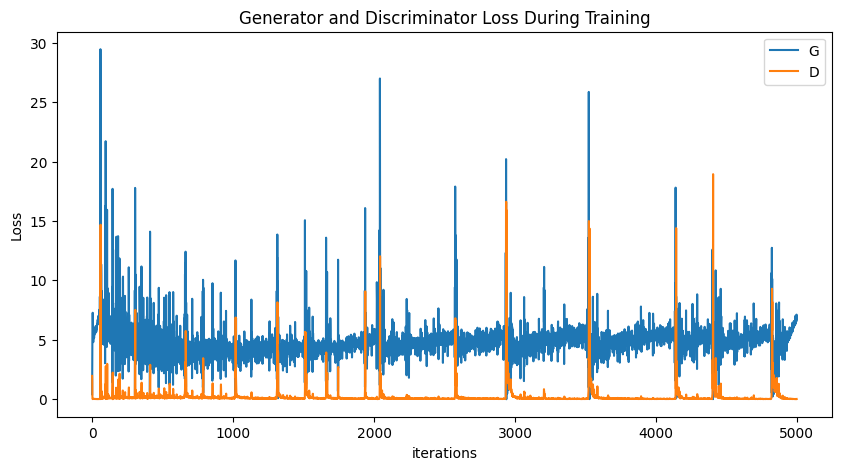

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

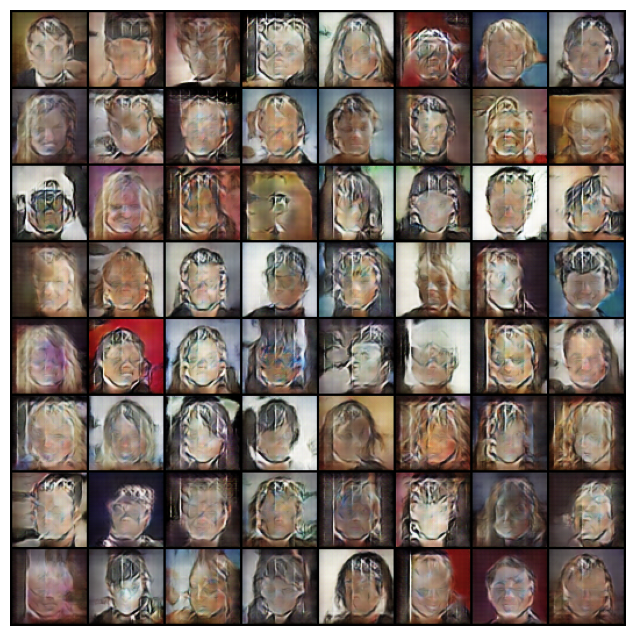

In [ ]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())

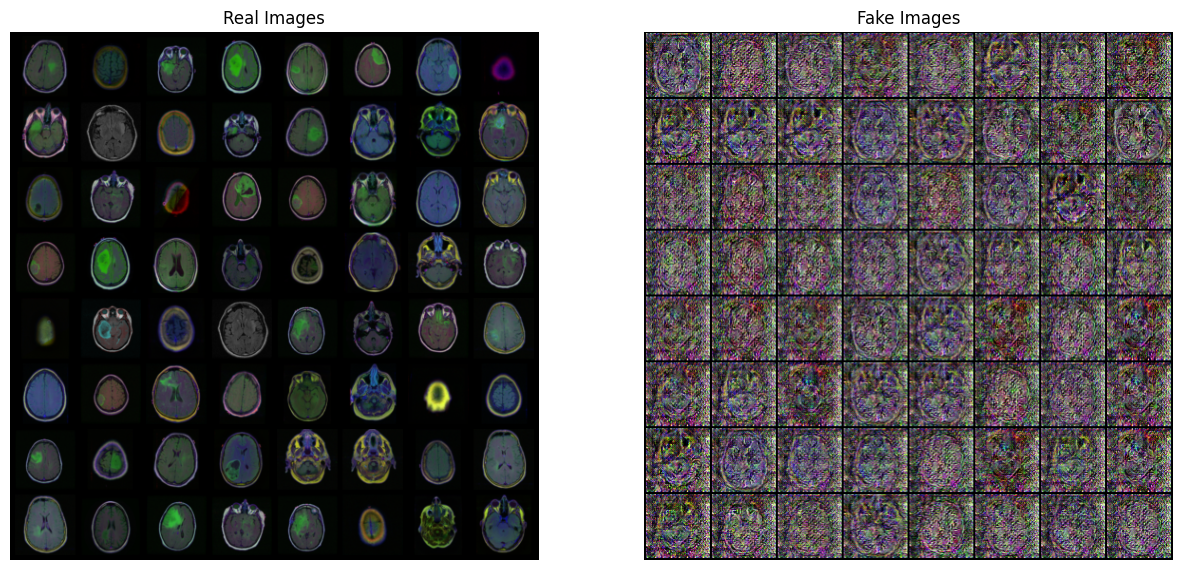

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(img_list[-1],(1,2,0)))
plt.show()

In [ ]:
model_save_path = "/content/drive/MyDrive/Colab_models/Brain_MRI_image_synthesis/DCGAN_pre_trained_celebA"
torch.save(netG.state_dict(), os.path.join(model_save_path,'Generator_model_weights.pth'))
torch.save(netD.state_dict(), os.path.join(model_save_path,'Descriminator_model_weights.pth'))